In [9]:
import plotting
import importlib
importlib.reload(plotting)
import scipy
import numpy as np
import transforms
import sampling
import matplotlib.pyplot as plt
import sys
#np.set_printoptions(suppress=True)
import chernoff
from tqdm import tqdm
np.set_printoptions(threshold=sys.maxsize)

In [2]:
ga,gb = 0.5,2
pi = 1/4
n = 64
rho = 1/4
svd_1d = sampling.SpecEmbed(d=1)
means, stds = [],[]
for n in [64,128,256,512,1024,2048]:
    res = np.zeros((6, 9))
    for i in tqdm(range(6)):
        itr = []
        gamma_dists, gamma_params = sampling.standard_dist_matrix(scipy.stats.gamma, [ga,0,1/gb])
        model = sampling.WSBM(f"$\Gamma[{ga},{gb}]$", gamma_dists, gamma_params, np.array([pi,1 - pi]))


        graph_orig = model.sample(n, rho)

        graph = transforms.PowerTransform.apply(1, graph_orig.graph)
        sums = np.sum(np.sort(graph)[:, :1], axis = 1)
        CI = chernoff.discretized_chernoff_information(sums[:int(pi * n)], sums[int(pi * n):])
        itr.append(CI)
        sums = np.sum(np.sort(graph)[:, :], axis = 1)
        CI = chernoff.discretized_chernoff_information(sums[:int(pi * n)], sums[int(pi * n):])
        itr.append(CI)

        graph = transforms.PowerTransform.apply(2, graph_orig.graph)
        sums = np.sum(np.sort(graph)[:, :1], axis = 1)
        CI = chernoff.discretized_chernoff_information(sums[:int(pi * n)], sums[int(pi * n):])
        itr.append(CI)
        sums = np.sum(np.sort(graph)[:, :], axis = 1)
        CI = chernoff.discretized_chernoff_information(sums[:int(pi * n)], sums[int(pi * n):])
        itr.append(CI)

        graph = transforms.PowerTransform.apply(3, graph_orig.graph)
        sums = np.sum(np.sort(graph)[:, :1], axis = 1)
        CI = chernoff.discretized_chernoff_information(sums[:int(pi * n)], sums[int(pi * n):])
        itr.append(CI)
        sums = np.sum(np.sort(graph)[:, :], axis = 1)
        CI = chernoff.discretized_chernoff_information(sums[:int(pi * n)], sums[int(pi * n):])
        itr.append(CI)

        graph = transforms.FisherTransform.apply(1, graph_orig.graph)
        sums = np.min(graph, axis = 1)
        CI = chernoff.discretized_chernoff_information(sums[:int(pi * n)], sums[int(pi * n):])
        itr.append(CI)
        sums = np.sum(graph, axis = 1)
        CI = chernoff.discretized_chernoff_information(sums[:int(pi * n)], sums[int(pi * n):])
        itr.append(CI)

        sums = svd_1d.fit_transform(graph)
        CI = chernoff.discretized_chernoff_information(sums[:int(pi * n)], sums[int(pi * n):])
        itr.append(CI)

        res[i] = itr
    means_ = np.mean(res, axis = 0)
    stds_ = np.std(res, axis = 0)
    means.append(means_), stds.append(stds_)


  0%|          | 0/6 [00:00<?, ?it/s]/home/adl/University/IV/M4R/sampling.py:8: RuntimeWarning: overflow encountered in exp
  return 1/(1 + np.exp(-x))
100%|██████████| 6/6 [00:33<00:00,  5.59s/it]


In [10]:
def new_transform(w, X):
    X = -np.log(1 - X)
    oldX = X
    for _ in range(w):
        P = np.sum(X, axis = 1)
        Xj = X * P
        X = (X @ Xj) / len(X)
    return X
        

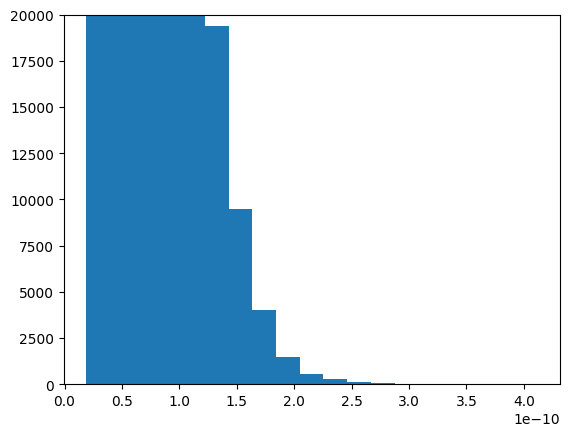

In [16]:
ga,gb = 0.5,2
pi = 0.25
n = 1000
rho = 0.1
#for n in [64,128,256,512,1024,2048,4096]:
gamma_dists, gamma_params = sampling.standard_dist_matrix(scipy.stats.gamma, [ga,0,1/gb])
model = sampling.WSBM(f"$\Gamma[{ga},{gb}]$", gamma_dists, gamma_params, np.array([pi,1 - pi]))


graph = model.sample(n, rho)

#graph.transform(lambda x : new_transform(1,x))
graph.transform(lambda x : transforms.PowerTransform.apply(10,x))
XX = graph.graph.flatten()
delt = np.max(XX) - np.min(XX)
bins = np.arange(np.min(XX), np.max(XX), delt/20)
plt.hist(graph.graph.flatten(), bins)
plt.ylim(0, 20_000)
plt.show()

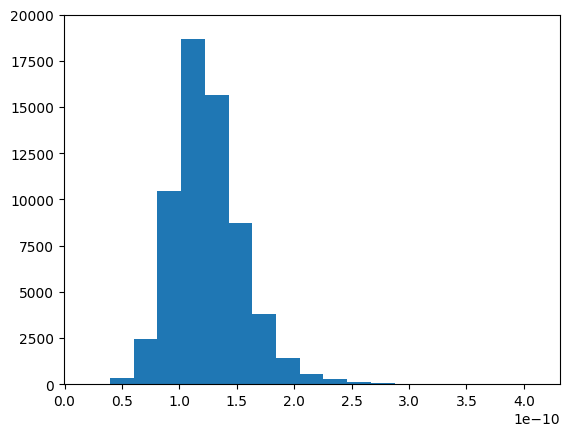

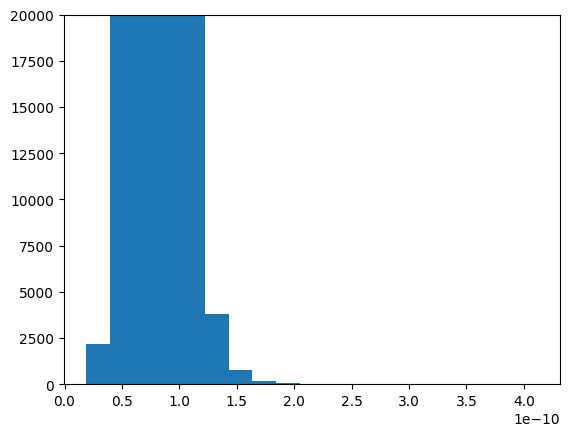

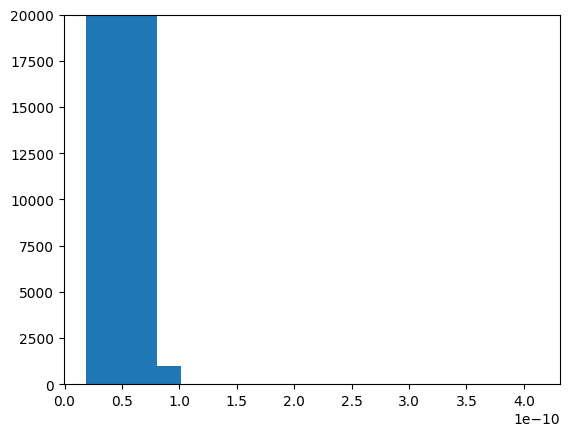

In [17]:
npi = int(n * pi)
h1_h1 = graph.graph[:npi, :npi].flatten()
h1_h0 = np.concatenate((graph.graph[:npi, npi:].flatten(), graph.graph[npi:, :npi].flatten()))
h0_h0 = graph.graph[npi:, npi:].flatten()

plt.hist(h1_h1, bins)
plt.ylim(0,20_000)
plt.show()
plt.hist(h1_h0, bins)
plt.ylim(0,20_000)
plt.show()
plt.hist(h0_h0, bins)
plt.ylim(0,20_000)
plt.show()

In [7]:
embedded_h1 = []
embedded_h0 = []

NG = graph.graph
ctr = 0
while len(NG) > 0:
    nid = len(NG)
    sums = np.sum(np.sort(NG)[:, :nid], axis = 1)
    bi = np.argmax(sums)
    if bi < npi:
        embedded_h1.append(sums[bi] / nid)
        npi -= 1
    else:
        embedded_h0.append(sums[bi] / nid)
    NG = np.delete(NG, bi, axis = 0)
    NG = np.delete(NG, bi, axis = 1)

27.13842410957261


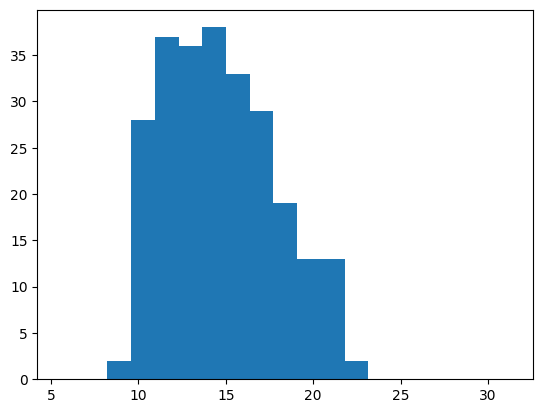

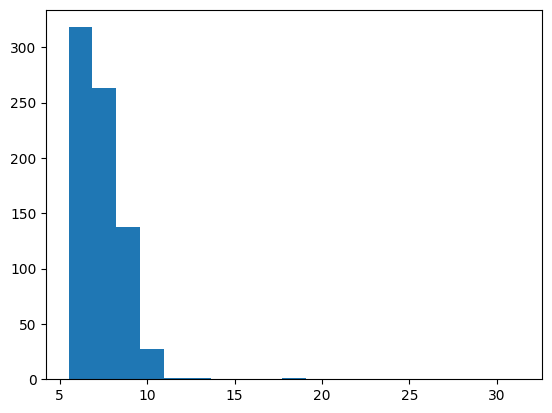

2.500650969624928


In [8]:
sums = np.array(embedded_h1 + embedded_h0)
delt = np.max(sums) - np.min(sums)
print (delt)
bins = np.arange(np.min(sums), np.max(sums), delt/20)
plt.hist(sums[:int(pi * n)], bins)
plt.show()
plt.hist(sums[int(pi * n):], bins)
plt.show()
print (chernoff.discretized_chernoff_information(sums[:int(pi * n)], sums[int(pi * n):]))

[2.65440399 3.18793769 3.39523606 4.42677214 2.71237526 2.71033314
 2.71677444 3.18039992 4.28598304 3.09125562]
4.086075648178314


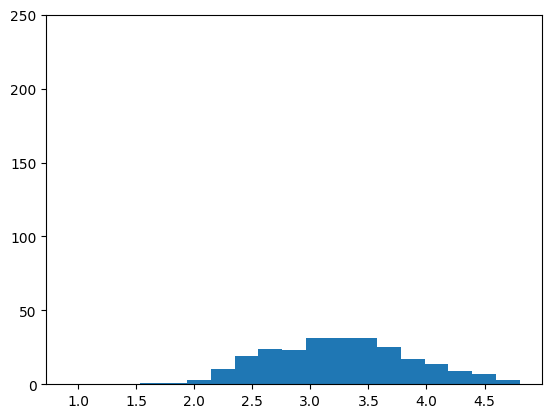

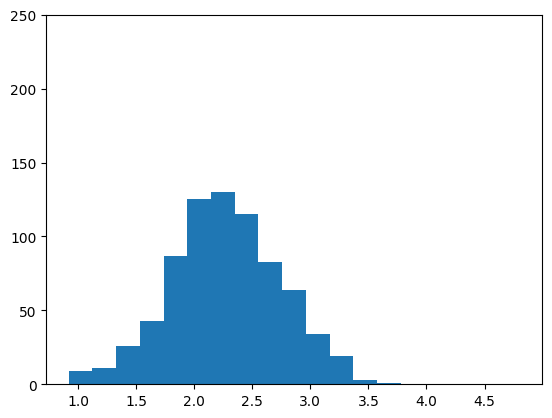

0.5924828260683268


In [5]:
sums = np.min(np.sort(graph.graph)[:, :], axis = 1)
svd_1d = sampling.SpecEmbed(d=1)
#sums = svd_1d.fit_transform(graph.graph).T[0]
print (sums[:10])
delt = np.max(sums) - np.min(sums)
print (delt)
bins = np.arange(np.min(sums), np.max(sums), delt/20)
plt.hist(sums[:int(pi * n)], bins)
plt.ylim((0, 250))
plt.show()
plt.hist(sums[int(pi * n):], bins)
plt.ylim((0, 250))
plt.show()
print (chernoff.discretized_chernoff_information(sums[:int(pi * n)], sums[int(pi * n):]))

[3.14130454 3.02807317 2.86274926 2.54795589 2.72377909 3.35722647
 4.06769897 3.05404584 3.53607424 3.34299416]
4.400045352722854


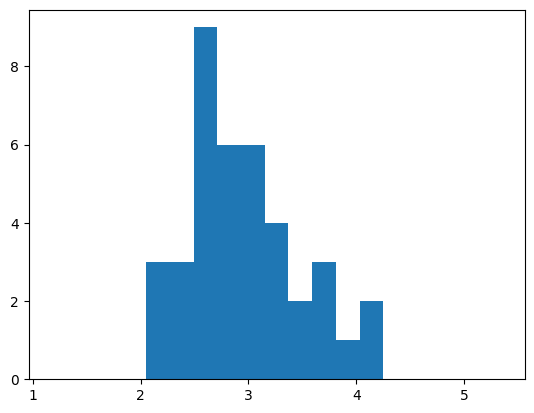

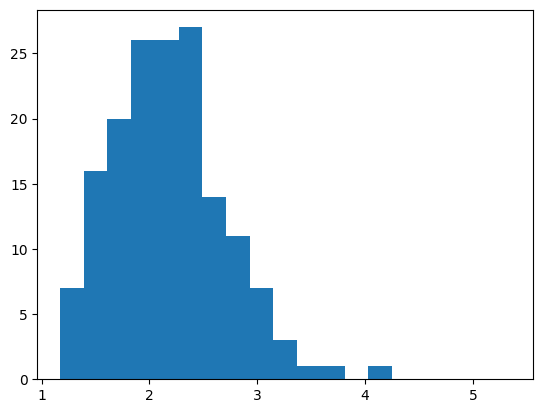

1.0498221244546548


In [6]:
sums = np.sum(np.sort(graph.graph)[:, :250], axis = 1)
print (sums[:10])
delt = np.max(sums) - np.min(sums)
print (delt)
bins = np.arange(np.min(sums), np.max(sums), delt/20)
plt.hist(sums[:int(pi * n)], bins)
plt.show()
plt.hist(sums[int(pi * n):], bins)
plt.show()
print (chernoff.discretized_chernoff_information(sums[:int(pi * n)], sums[int(pi * n):]))

[3.14130454 3.02807317 2.86274926 2.54795589 2.72377909 3.35722647
 4.06769897 3.05404584 3.53607424 3.34299416]
4.400045352722854


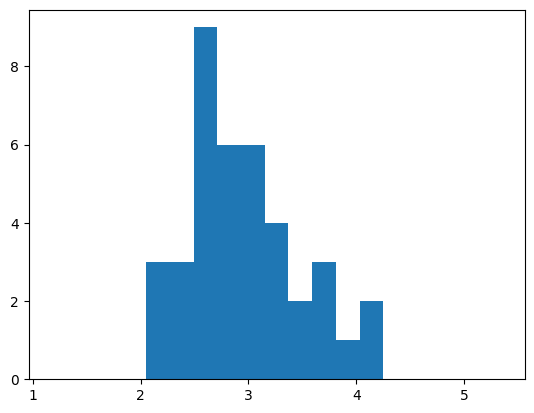

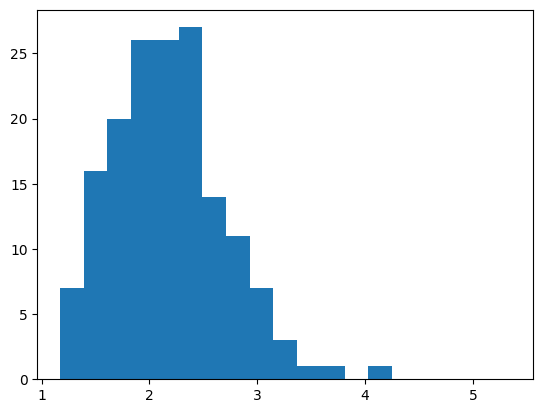

1.0498221244546548


In [7]:

sums = np.sum(np.sort(graph.graph)[:, :], axis = 1)
print (sums[:10])
delt = np.max(sums) - np.min(sums)
print (delt)
bins = np.arange(np.min(sums), np.max(sums), delt/20)
plt.hist(sums[:int(pi * n)], bins)
plt.show()
plt.hist(sums[int(pi * n):], bins)
plt.show()
print (chernoff.discretized_chernoff_information(sums[:int(pi * n)], sums[int(pi * n):]))

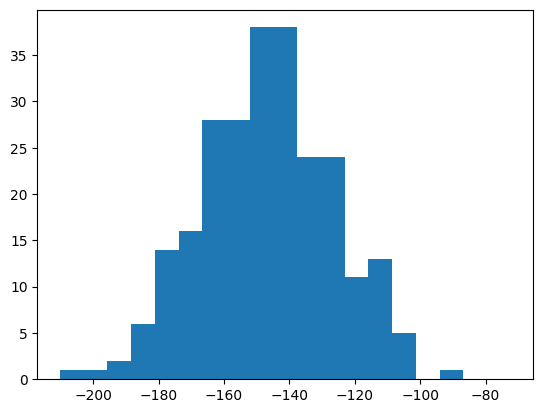

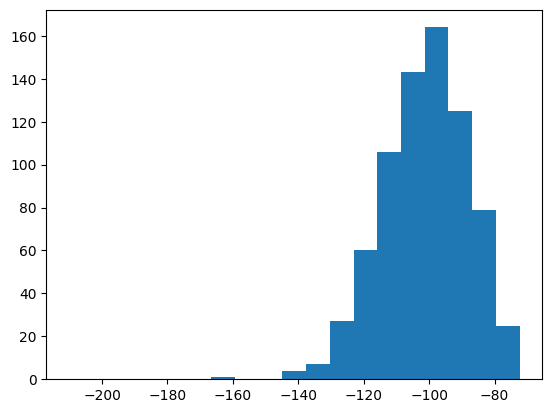

1.2250550553540105


In [6]:
graph.untransform()
graph.transform(lambda x : transforms.FisherTransform.apply(0,x))
sums = np.sum(graph.graph, axis = 1)
delt = np.max(sums) - np.min(sums)
bins = np.arange(np.min(sums), np.max(sums), delt/20)
plt.hist(sums[:int(pi * n)], bins)
plt.show()
plt.hist(sums[int(pi * n):], bins)
plt.show()
print (chernoff.discretized_chernoff_information(sums[:int(pi * n)], sums[int(pi * n):]))

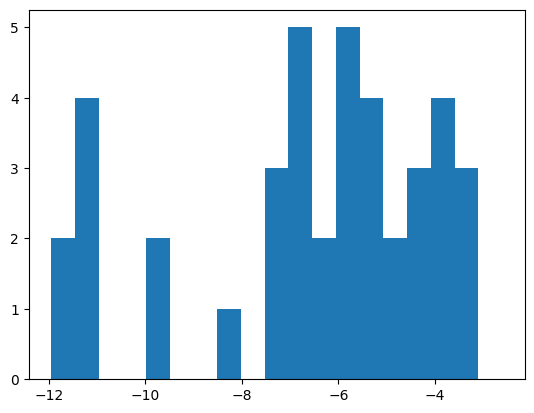

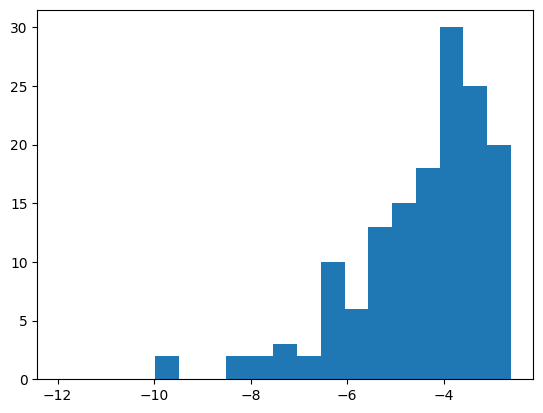

1.203972799078413


In [9]:
sums = np.min(graph.graph, axis = 1)
delt = np.max(sums) - np.min(sums)
bins = np.arange(np.min(sums), np.max(sums), delt/20)
plt.hist(sums[:int(pi * n)], bins)
plt.show()
plt.hist(sums[int(pi * n):], bins)
plt.show()
print (chernoff.discretized_chernoff_information(sums[:int(pi * n)], sums[int(pi * n):]))

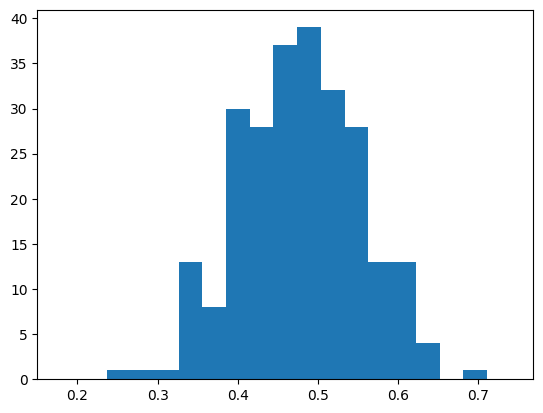

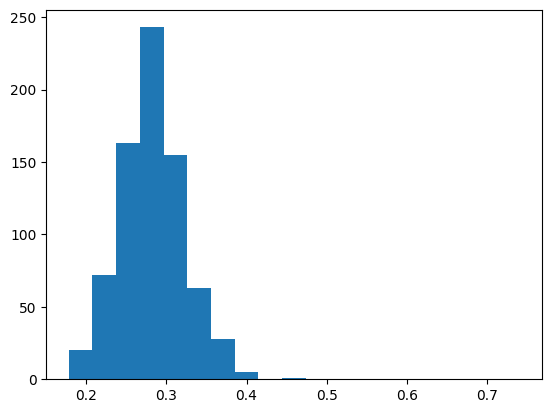

1.961263605513945


In [7]:
svd_1d = sampling.SpecEmbed(d=1)
sums = svd_1d.fit_transform(graph.graph).T[0]
delt = np.max(sums) - np.min(sums)
bins = np.arange(np.min(sums), np.max(sums), delt/20)
plt.hist(sums[:int(pi * n)], bins)
plt.show()
plt.hist(sums[int(pi * n):], bins)
plt.show()
print (chernoff.discretized_chernoff_information(sums[:int(pi * n)], sums[int(pi * n):]))

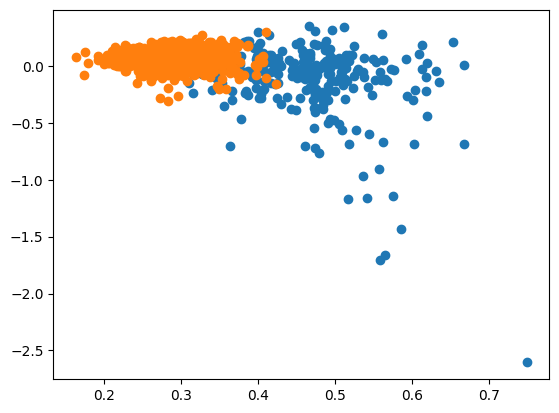

1.3591321577685336

In [31]:
svd_2d = sampling.SpecEmbed(d=2)
pts = svd_2d.fit_transform(graph.graph)
plt.scatter(pts[:int(pi * n), 0], pts[:int(pi * n), 1])
plt.scatter(pts[int(pi * n):,0], pts[int(pi * n):,1])
plt.show()
chernoff.d2_discretized_chernoff_information(pts[:int(pi * n)], pts[int(pi * n):], 10)

In [12]:
assert False

AssertionError: 

In [ ]:
pi = 0.1
S_PI = [pi, (1 - pi)]
for ga in [0.5,1,2]:
    for gb in [2,1,0.5]:
        w = -1
        if 1 + gb - ga != 0:
            w = (1 - ga)/(1 + gb - ga)
        gamma_dists, gamma_params = sampling.standard_dist_matrix(scipy.stats.beta, [ga,gb])
        model = sampling.WSBM(f"$\Gamma[{ga},{gb}]$", gamma_dists, gamma_params, np.array([0.2,0.8]))
        plotting.plot_transforms_analytic(model, transforms.TRANSFORMS, 1, gran = 5)
        break
    break